# Previsão de temperatura com *AutoML* para Séries Temporais

Muitas vezes quando queremos trabalhar com séries temporais, precisamos selecionar o modelo que melhor modele os dados e gere boa previsões. Muitos desses modelos possuem várias etapas (como o ARIMA ou VAR) e podem não funcionar, dependendo da série temporal. 

Por esse motivo escolhemos utilizar uma biblioteca que automatiza esse processo de seleção de modelo. O objetivo desse projeto é utilizar a biblioteca de *Auto Machine Learning auto-ts* para previsão da temperatura média da cidade de Déli, na índia. Essa biblioteca usa modelos das bibliotecas *Facebook Prophet*, *PyFlux* e *Stasmodels*. 

## Dados

Os dados se referem a séries temporais de 4 variáveis, que são:

1)  *meantemp* (temperatura média): calculada a partir de vários intervalos de 3 horas em um dia;

2) *humidity* (humidade): Valor de umidade do dia (unidades são gramas de vapor de água por metro cúbico de volume de ar);

3) *wind_speed* (velocidade do tempo): Velocidade do vento medida em km/h;

4) *meanpressure* (pressão média): Leitura da pressão do tempo (medida em atm).

A periodicidade dos dados é diária e vão de 1º de janeiro de 2013 a 24 de abril de 2017. Os dados podem ser obtidos [aqui](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data).


## Importando as bibliotecas

Precisaremos instalar a biblioteca *auto-ts*.

In [2]:
!pip install auto-ts

     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 1.3MB 6.8MB/s 
     |████████████████████████████████| 962kB 34.4MB/s 
  Created wheel for pyflux: filename=pyflux-0.4.15-cp36-cp36m-linux_x86_64.whl size=4656562 sha256=b00b5daa6452cfd67fb9cb1895d6ddba68339998c733549101aecec8624a580b
  Stored in directory: /root/.cache/pip/wheels/36/24/09/d18fa4f926cc90598d23ebd09fb4b0fd7b3dd1d2f506b952de
Successfully built pyflux


In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import auto_ts as AT
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

## Importando os dados

In [4]:
from google.colab import files
uploaded= files.upload()

Saving DailyDelhiClimateTest.csv to DailyDelhiClimateTest.csv
Saving DailyDelhiClimateTrain.csv to DailyDelhiClimateTrain.csv


In [11]:
clima_treino=pd.read_csv('DailyDelhiClimateTrain.csv')
clima_teste=pd.read_csv('DailyDelhiClimateTest.csv')

Vamos transformar a coluna *date* em formato *datetime*.

In [12]:
clima_treino['date']=pd.to_datetime(clima_treino['date'])
clima_teste['date']=pd.to_datetime(clima_teste['date'])

## Análise exploratória dos dados

A base de treino tem 1462 observações e a base de treino tem 114 observações.

In [13]:
display(clima_treino.shape)
display(clima_teste.shape)

(1462, 5)

(114, 5)

Primeiras 10 observações da base de dados de treino.

In [14]:
clima_treino.head(10)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286
8,2013-01-09,14.000000,51.250000,12.500000,1017.000000
9,2013-01-10,11.000000,62.000000,7.400000,1015.666667


Primeiras 10 observações da base de dados de teste.

In [15]:
clima_teste.head(10)

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
5,2017-01-06,19.318182,79.318182,8.681818,1011.772727
6,2017-01-07,14.708333,95.833333,10.041667,1011.375000
7,2017-01-08,15.684211,83.526316,1.950000,1015.550000
8,2017-01-09,14.571429,80.809524,6.542857,1015.952381
9,2017-01-10,12.111111,71.944444,9.361111,1016.888889


#### Informações sobre os dados

Vamos que a variável *date* está no formato *datetime*, como convertemos anteriormente; e as demais observações estão no formato *float*.

In [16]:
display(clima_treino.info())
display(clima_teste.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          114 non-null    datetime64[ns]
 1   meantemp      114 non-null    float64       
 2   humidity      114 non-null    float64       
 3   wind_speed    114 non-null    float64       
 4   meanpressure  114 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 4.6 KB


None

Vamos colocar a coluna *date* como o índice das nossas bases de dados.

In [17]:
clima_treino=clima_treino.set_index('date')
clima_teste=clima_teste.set_index('date')


As nossas bases não possuem valores faltantes.

In [18]:
display(clima_treino.isna().sum())
display(clima_teste.isna().sum())

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Tabelas estatísticas das bases de treino e teste.

In [ ]:
display(clima_treino.describe())
display(clima_teste.describe())

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


,meantemp,humidity,wind_speed,meanpressure
count,114.000000,114.000000,114.000000,114.000000
mean,21.713079,56.258362,8.143924,1004.035090
std,6.360072,19.068083,3.588049,89.474692
min,11.000000,17.750000,1.387500,59.000000
25%,16.437198,39.625000,5.563542,1007.437500
50%,19.875000,57.750000,8.069444,1012.739316
75%,27.705357,71.902778,10.068750,1016.739583
max,34.500000,95.833333,19.314286,1022.809524


Abaixo vemos os valores para a base de treino e teste da coluna *meantemp* (temperatura média). Podemos observar que ela possui um forte sazonalidade, com temperaturas médias baixas no começo e fim dos anos e picos de temperatura média por volta do meio do ano.

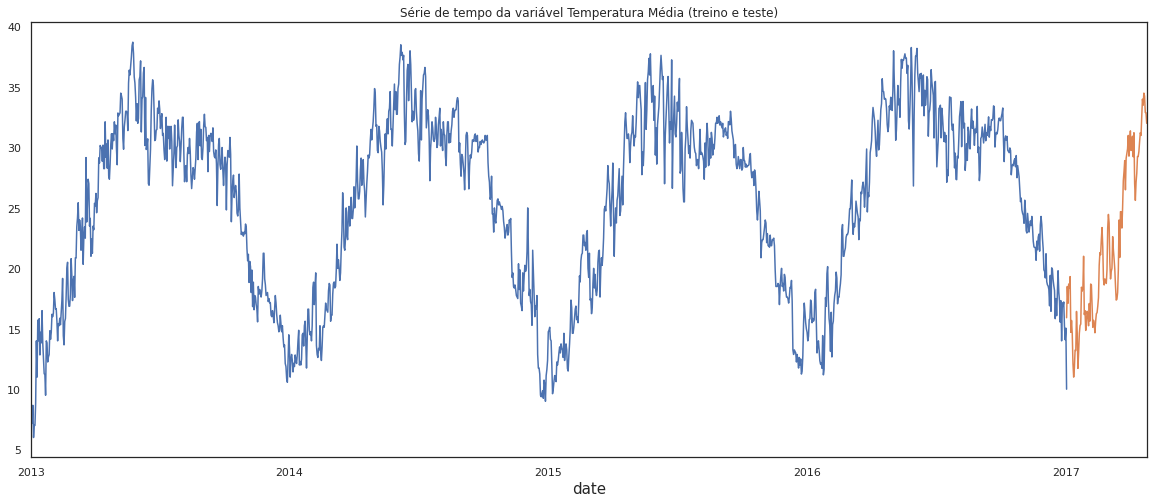

In [19]:
plt.figure(figsize=(20,8))
plt.xlabel('Datas',size=15)
plt.title('Série de tempo da variável Temperatura Média (treino e teste)')
clima_treino['meantemp'].plot()
clima_teste['meantemp'].plot();

Abaixo vemos a série de humidade, que também possui forte presença de sazonalidade, porém com valores menores para o meio do ano (que coincide com as temperaturas médias altas nesse período).

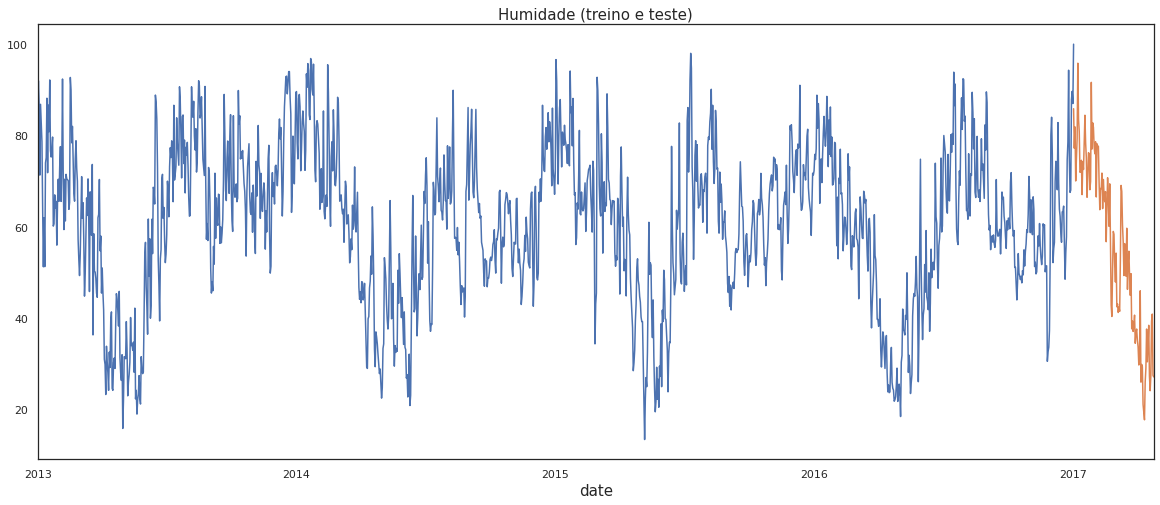

In [20]:
plt.figure(figsize=(20,8))
plt.xlabel('Datas',size=15)
plt.title('Humidade (treino e teste)',size=15)
clima_treino['humidity'].plot()
clima_teste['humidity'].plot();

Em *wind_speed* (Velocidade do vento) também vemos a preseça de sazonalidade. A velocidade do vento é menor no começo/final dos anos e maior no meio dos anos (semelhante ao que acontece com a temperatura média).

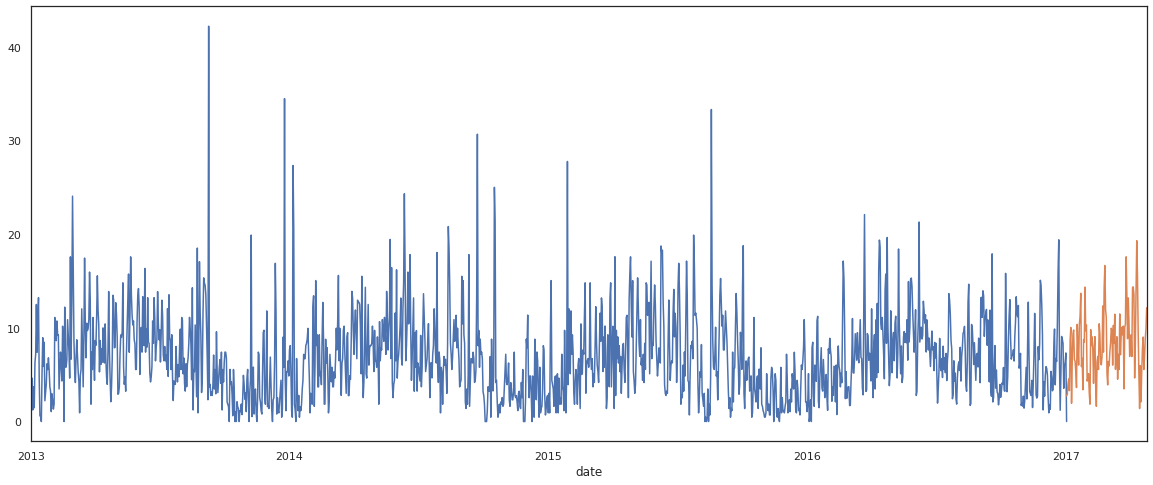

In [21]:
plt.figure(figsize=(20,8))
clima_treino['wind_speed'].plot()
clima_teste['wind_speed'].plot();

Por fim, podemos visualizar a coluna *meanpressure* (Pressão média).

A série aperenta não ser tão interessante ou com detalhes expressivos como as variáveis anteriores, mas o que podemos notar são algumas observações, no final da série abaixo, que aperentam ser *outliers*.

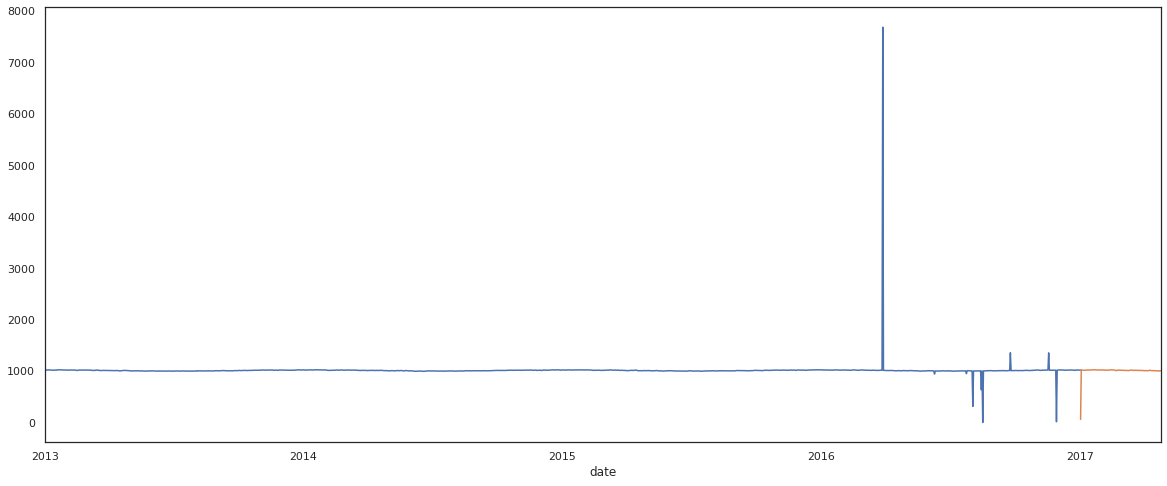

In [ ]:
plt.figure(figsize=(20,8))
clima_treino['meanpressure'].plot()
clima_teste['meanpressure'].plot();

Distribuição das colunas da base de treino

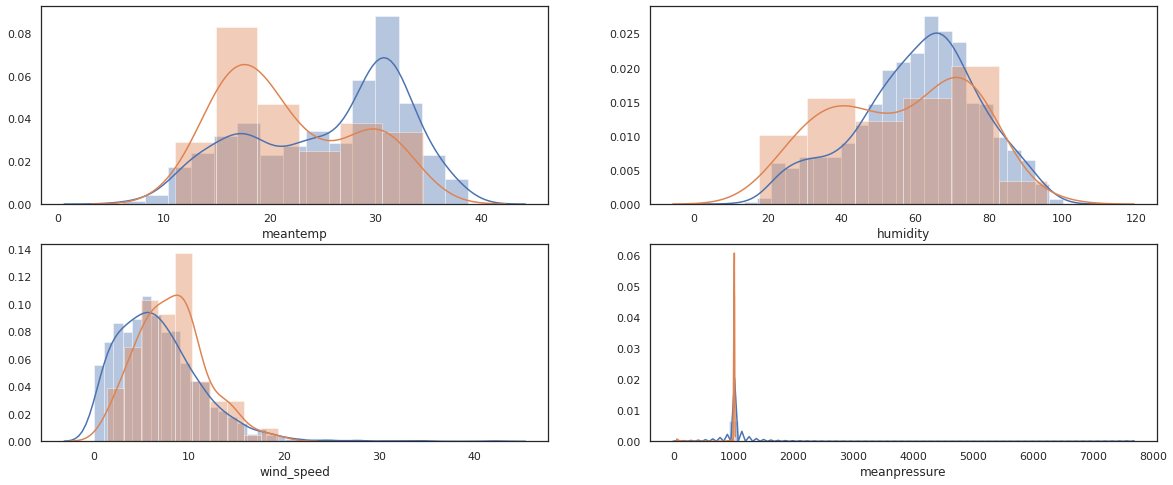

In [31]:
fig,ax=plt.subplots(2,2,figsize=(20,8))
sns.distplot(clima_treino['meantemp'],ax=ax[0][0])
sns.distplot(clima_treino['humidity'],ax=ax[0][1])
sns.distplot(clima_treino['wind_speed'],ax=ax[1][0])
sns.distplot(clima_treino['meanpressure'],ax=ax[1][1])

sns.distplot(clima_teste['meantemp'],ax=ax[0][0])
sns.distplot(clima_teste['humidity'],ax=ax[0][1])
sns.distplot(clima_teste['wind_speed'],ax=ax[1][0])
sns.distplot(clima_teste['meanpressure'],ax=ax[1][1]);

Agora vamos ver a distribuição das colunas com todos os dados juntos (de treino e de teste).

In [39]:
clima=pd.concat([clima_treino,clima_teste])

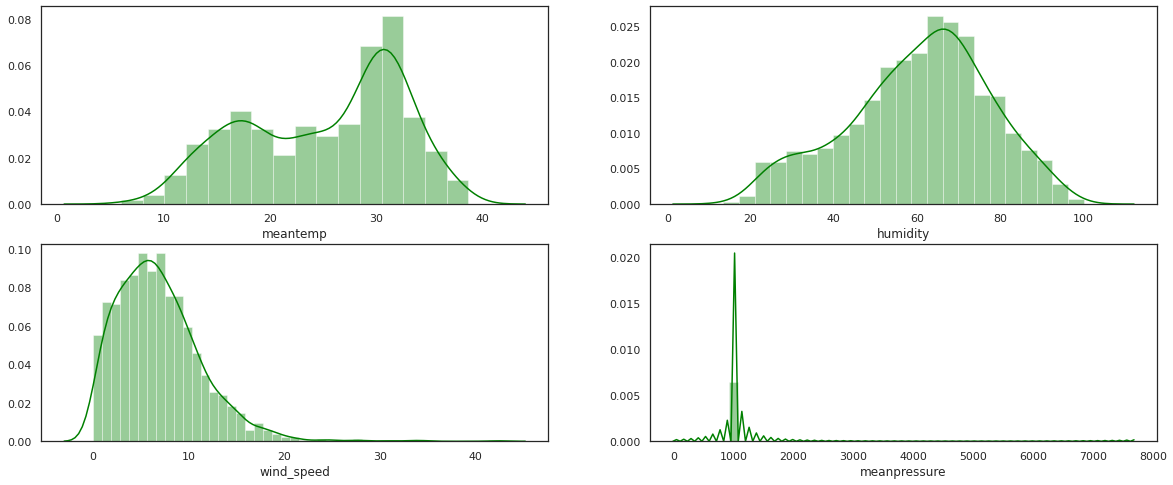

In [41]:
fig,ax=plt.subplots(2,2,figsize=(20,8))
sns.distplot(clima['meantemp'],ax=ax[0][0],color='green')
sns.distplot(clima['humidity'],ax=ax[0][1],color='green')
sns.distplot(clima['wind_speed'],ax=ax[1][0],color='green')
sns.distplot(clima['meanpressure'],ax=ax[1][1],color='green');

### Correlação entre as *features*

Vemos que as *features* são pouco correlacionadas com a variável *meantemp*, que será nossa variável *target*.

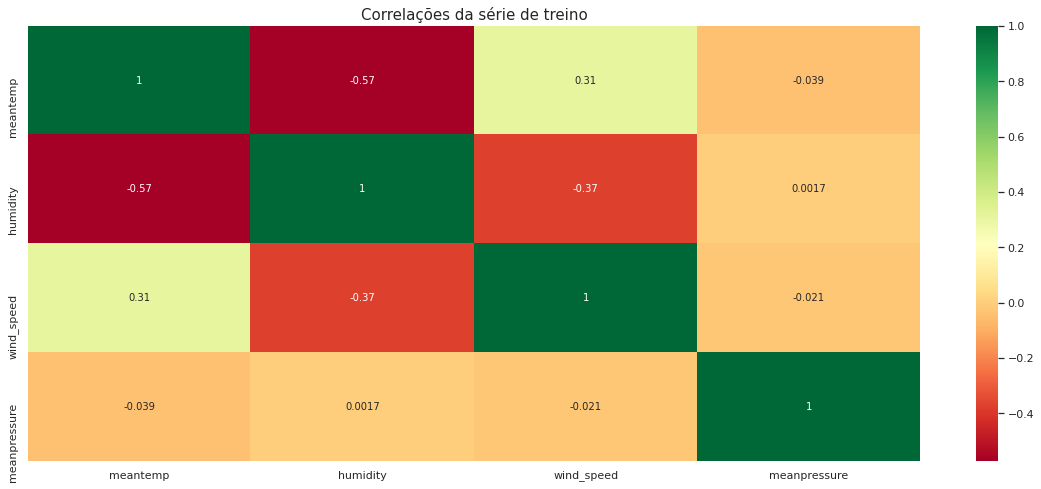

In [27]:

%matplotlib inline
plt.figure(figsize=(20,8))
plt.title("Correlações da série de treino", size=15)
sns.heatmap(clima_treino.corr(), annot = True, cmap= "RdYlGn");

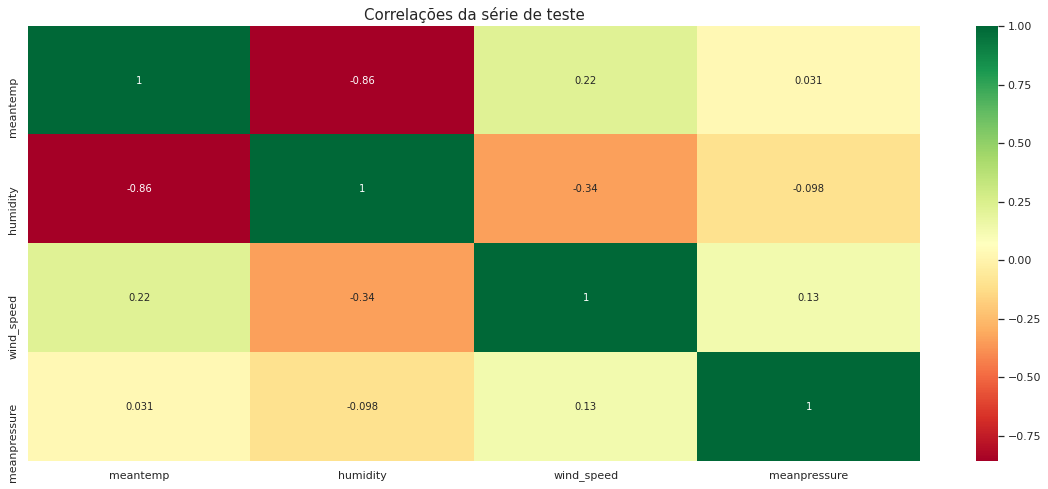

In [28]:
%matplotlib inline
plt.figure(figsize=(20,8))
plt.title("Correlações da série de teste", size=15)
sns.heatmap(clima_teste.corr(), annot = True, cmap= "RdYlGn");

## Modelagem com *Auto Machine Learning*

Vamos primeiro importar novamente os dados para que tenhamos a coluna *date* novamente.

In [43]:
clima_treino=pd.read_csv('DailyDelhiClimateTrain.csv')
clima_teste=pd.read_csv('DailyDelhiClimateTest.csv')

Agora vamos aplicar a *auto-ts*.

Essa biblioteca vai utilizar os principais métodos para séries temporais, que são:

1) Modelagem univariada (ARIMA e SARIMAX);

2) Modelagem multivariada (Model VAR);

3) Modelos de *Machine Learning*;

4) Biblioteca *Facebook Phophet*.


A biblioteca será treinada com a base *clima_treino* e a variável *target* (que queremos que seja gerada as previsões) será a *meantemp*.

Vamos gerar 114 previsões diárias e vamos compará-las com os 114 reais da variável *meantemp* na base *clima_teste*. Além de compararmos visualmente, usaremos a métricas *RMSE* (Raiz da média dos erros quadrados).

Input is data frame. Performing Time Series Analysis
    Dataframe loaded successfully. Shape of data set = (1462, 4)
    Target variable = meantemp
Time Interval is given as days

Running Facebook Prophet Model...
Preparing Time Series data for FB Prophet: sample row before
             meantemp  humidity  wind_speed  meanpressure
date                                                    
2013-01-01      10.0      84.5         0.0   1015.666667
Time Series data: sample row after transformation
           ds     y  humidity  wind_speed  meanpressure
0 2013-01-01  10.0      84.5         0.0   1015.666667
    Fit-Predict data (shape=(1462, 2)) with Confidence Interval = 0.95...
Building Forecast dataframe. Forecast Period = 114


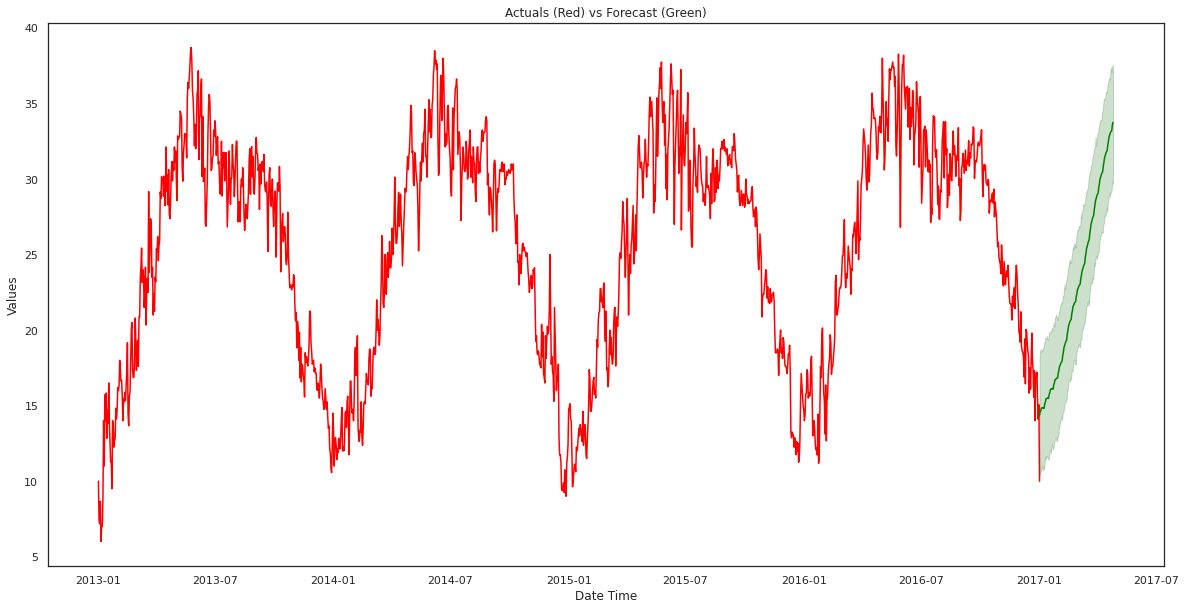

    RMSE = 4.38
    Std Deviation of Originals = 7.35
    Normalized RMSE = 60%

Running PyFlux Model...
Cycling through various (p,d,q) parameters

Best Params Selected (based on rmse): (3, 1, 3)
Dynamic 114-period Forecasts:
    RMSE = 8.23
    Std Deviation of Originals = 7.46
    Normalized RMSE = 110%

Running Non Seasonal ARIMA Model...

Differencing = 0
 Iteration 0 completed...
 Iteration 10 completed...
    Best AR order p = 1, MA order q = 3, Interim metric = 5158.781

Differencing = 1
 Iteration 20 completed...
 Iteration 30 completed...
    Best AR order p = 3, MA order q = 3, Interim metric = 5148.138

Best model is: Non Seasonal ARIMA(3,1,3), aic = 5148.138
####    Fitting best model for full data set now. Will take time... ######
Static Forecasts:
Dynamic predictions erroring but continuing...

Dynamic 114-period Forecasts:
                             ARIMA Model Results                              
Dep. Variable:             D.meantemp   No. Observations:             

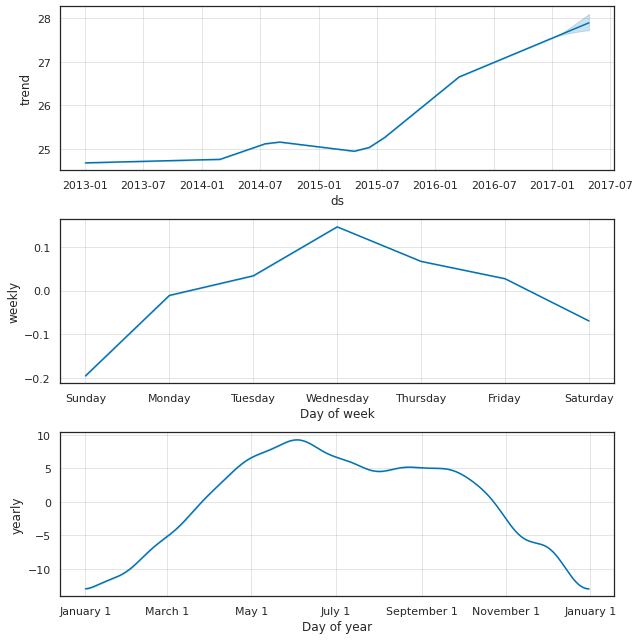

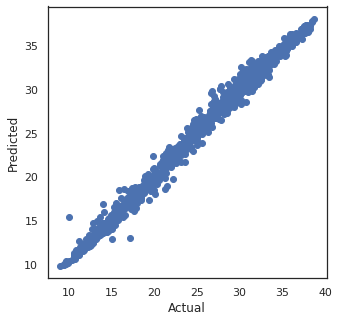

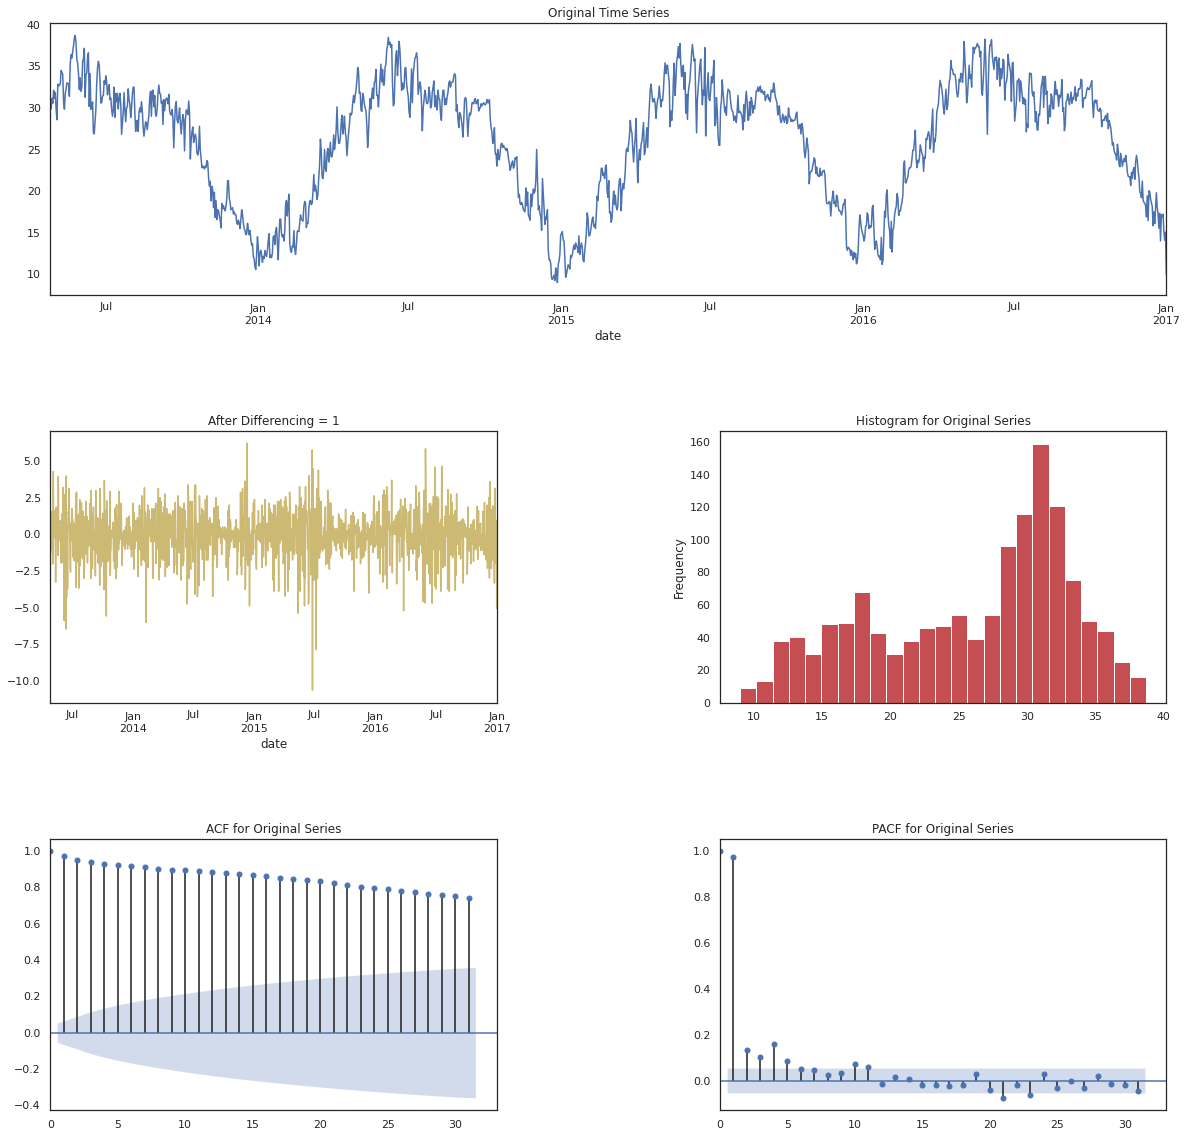


Best Model is:
    ML
    Best Model Forecasts: [30.59879632 30.69562698 30.23441176 31.03812315 32.09715741 30.28995505
 31.44699377 31.44625373 31.52551007 31.38603521 31.39424817 31.67178704
 31.74450794 30.25296306 30.32818706 30.40394139 29.80000796 30.62375944
 30.91202116 31.67002666 31.2206628  31.22856593 32.01574463 31.67911722
 31.69367857 30.12742011 28.50757798 30.42867857 30.49118081 29.88467857
 30.21819897 29.34386434 29.1893254  29.05186991 30.03484392 30.04984656
 27.71978571 28.10363333 28.18039524 27.99402381 28.41289524 28.41478571
 27.9845     28.46563333 27.58128571 27.49501852 27.35678571 26.97590476
 26.98955642 26.8805     26.49734524 24.77911905 24.19321429 23.72746429
 23.79780952 25.9584881  24.60266667 22.77875    22.89614286 23.92061905
 23.69141667 23.15933333 23.44315476 23.74244048 23.3872381  23.71861905
 23.17258333 22.68529762 22.06494048 21.551      21.40744048 19.76988095
 22.17189286 21.53630952 22.81238095 22.72007143 21.72516667 23.19653571
 2

In [45]:
sep=','
ml_dict=AT.Auto_Timeseries(clima_treino, 'date','meantemp',sep, score_type='rmse',forecast_period=114,time_interval='days',non_seasonal_pdq=None,seasonality=False,seasonal_period=365,seasonal_PDQ=None,
                           model_type='best',verbose=2)

## Comparando os resultados

Analisando o relatório gerado acima temos os seguintes resultados:

| ||   *RMSE*   ||  *Std of deviation original*  ||  *RMSE Normalizado*||
|:----------------:||:------------------:||:------------------:||:------------------:||
|Prophet || 4.38|| 7.35 || 60%||
|ARIMA (3,1,3) || 8.23|| 7.46 || 110%||
|SARIMAX(2,0,3) || 5.96|| 7.46 || 80%||
|VAR || 6.58|| 7.45 || 88%||
|*Maxchine Learning* || 1.36|| 7.3 || 19%||

Com base nesses resultados escolheríamos o modelo de *Machine Learning* como melhor modelo, por apresentar as menores métricas de avaliação, porém com os resultados apontando para essa escolha, precisamos comparar os valores preditos com os valores reais. Iremos fazer isso de forma gráfica e por meio de métricas de avaliação, que serão:

1) *Mean Squared Error* (erro médio quadrado);

2) *Root Mean Squared Error* (raiz do erro médio quadrado);

3) *Mean Absolute Error* (Erro médio absoluto);

4) *Mean Squared Log Error* (Logarítimo do erro médio quadrado);

5) *Median absolute error* (Erro mediano absoluto)*

6) $R^2$ (R quadrado - medida de poder explicativo do modelo).


### Análise do modelo *Facebook Prophet*

O primeiro modelo que vamos analisar é o *Facebook Prophet*. Vemos que o modelo identificou bem a tendência dos dados, mas parece que não captou a sazonalidade dos dados.

<Figure size 1440x360 with 0 Axes>

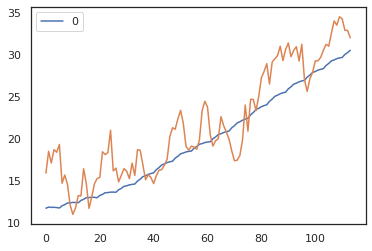

In [46]:
plt.figure(figsize=(20,5))
pd.DataFrame(ml_dict['FB_Prophet']['forecast'][:114]).plot()
clima_teste['meantemp'].plot();

Métricas de avaliação dos erros do modelo *Facebook Prophet*.

In [68]:
print('A raiz do erro quadrado médio do modelo Facebook Prophet é :',
      round(rmse(pd.DataFrame(ml_dict['FB_Prophet']['forecast'][:114]),pd.DataFrame(clima_teste['meantemp']))[0],3))
print('O erro médio absoluto do modelo Facebook Prophet é :',
      round(mean_absolute_error(pd.DataFrame(ml_dict['FB_Prophet']['forecast'][:114]),pd.DataFrame(clima_teste['meantemp'])),3))
print('O erro quadrado médio do modelo Facebook Prophet é :',
      round(mean_squared_error(pd.DataFrame(ml_dict['FB_Prophet']['forecast'][:114]),pd.DataFrame(clima_teste['meantemp'])),3))
print('O erro médio quadrado logarítmico do modelo FacebooK Prophet é:',
      round(mean_squared_log_error(pd.DataFrame(ml_dict['FB_Prophet']['forecast'][:114]),pd.DataFrame(clima_teste['meantemp'])),3))
print('O erro mediano absoluto do modelo Facebook Prophet é:',
      round(median_absolute_error(pd.DataFrame(ml_dict['FB_Prophet']['forecast'][:114]),pd.DataFrame(clima_teste['meantemp'])),3))
print('O R-squared do modelo Facebook Prophet é:',
      round(r2_score(pd.DataFrame(ml_dict['FB_Prophet']['forecast'][:114]),pd.DataFrame(clima_teste['meantemp'])),3)*100,'%')

A raiz do erro quadrado médio do modelo Facebook Prophet é : 3.173
O erro médio absoluto do modelo Facebook Prophet é : 2.558
O erro quadrado médio do modelo Facebook Prophet é : 10.071
O erro médio quadrado logarítmico do modelo FacebooK Prophet é: 0.025
O erro mediano absoluto do modelo Facebook Prophet é: 2.193
O R-squared do modelo Facebook Prophet é: 70.3 %


### Análise do modelo de *Machine Learning*

O modelo de *Machine Learning* (uma *Random Forest*) não foi bem, como podemos ver abaixo e as suas métricas de avaliação foram maiores que as do modelo *Facebook Prophet*.

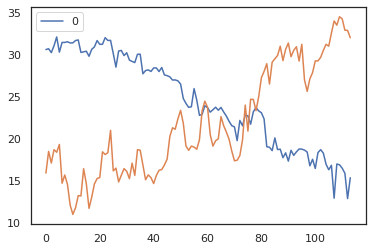

In [48]:
pd.DataFrame(ml_dict['ML']['forecast'][:114]).plot()
clima_teste['meantemp'].plot();

Métricas de avaliação do modelo de *machine learning*.

In [69]:
print('A raiz do erro quadrado médio do modelo de Machine Learning é :',
      round(rmse(pd.DataFrame(ml_dict['ML']['forecast'][:114]),pd.DataFrame(clima_teste['meantemp']))[0],3))
print('O erro médio absoluto do modelo de Machine Learning é :',
      round(mean_absolute_error(pd.DataFrame(ml_dict['ML']['forecast'][:114]),pd.DataFrame(clima_teste['meantemp'])),3))
print('O erro quadrado médio do modelo de Machine Learning é :',
      round(mean_squared_error(pd.DataFrame(ml_dict['ML']['forecast'][:114]),pd.DataFrame(clima_teste['meantemp'])),3))
print('O erro médio quadrado logarítmico de Machine Learning é:',
      round(mean_squared_log_error(pd.DataFrame(ml_dict['ML']['forecast'][:114]),pd.DataFrame(clima_teste['meantemp'])),3))
print('O erro mediano absoluto do modelo de Machine Learning é:',
      round(median_absolute_error(pd.DataFrame(ml_dict['ML']['forecast'][:114]),pd.DataFrame(clima_teste['meantemp'])),3))
print('O R-squared do modelo de Machine Learning é:',
      round(r2_score(pd.DataFrame(ml_dict['ML']['forecast'][:114]),pd.DataFrame(clima_teste['meantemp'])),3)*100,'%')

A raiz do erro quadrado médio do modelo de Machine Learning é : 11.747
O erro médio absoluto do modelo de Machine Learning é : 10.357
O erro quadrado médio do modelo de Machine Learning é : 137.99
O erro médio quadrado logarítmico de Machine Learning é: 0.253
O erro mediano absoluto do modelo de Machine Learning é: 11.639
O R-squared do modelo de Machine Learning é: -376.2 %


### Análise do modelo ARIMA

O modelo ARIMA também não teve um bom resultado.

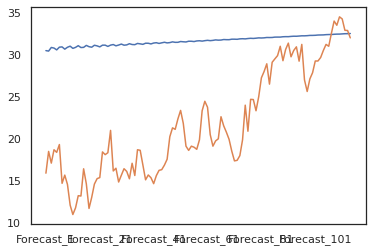

In [50]:
ml_dict['ARIMA']['forecast']['mean'].plot()
clima_teste['meantemp'].plot();

Métricas de avaliação do modelo ARIMA.

In [88]:
print('A raiz do erro quadrado médio do modelo ARIMA é :',
      round(rmse(ml_dict['ARIMA']['forecast']['mean'],clima_teste['meantemp'])))
print('O erro médio absoluto do modelo ARIMA é :',
      round(mean_absolute_error(ml_dict['ARIMA']['forecast']['mean'],clima_teste['meantemp'])))
print('O erro quadrado médio do modelo ARIMA é :',
      round(mean_squared_error(ml_dict['ARIMA']['forecast']['mean'],clima_teste['meantemp'])))
print('O erro médio quadrado logarítmico ARIMA é:',
      round(mean_squared_log_error(ml_dict['ARIMA']['forecast']['mean'],clima_teste['meantemp'])))
print('O erro mediano absoluto do modelo ARIMA é:',
      round(median_absolute_error(ml_dict['ARIMA']['forecast']['mean'],clima_teste['meantemp'])))
print('O R-squared do modelo ARIMA é:',
      round(r2_score(ml_dict['ARIMA']['forecast']['mean'],clima_teste['meantemp']))*100,'%')

A raiz do erro quadrado médio do modelo ARIMA é : 12.0
O erro médio absoluto do modelo ARIMA é : 10.0
O erro quadrado médio do modelo ARIMA é : 133.0
O erro médio quadrado logarítmico ARIMA é: 0.0 4
O erro mediano absoluto do modelo ARIMA é: 12.0
O R-squared do modelo ARIMA é: -46300.0 %


### Análise do modelo SARIMAX

Os valores preditos do modelo SARIMAX também não foram satisfatórios.

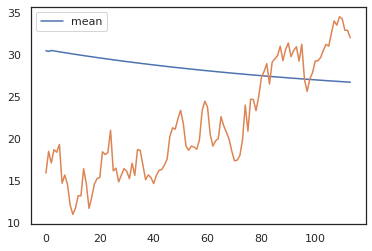

In [52]:
pd.DataFrame(ml_dict['SARIMAX']['forecast'].set_index(clima_teste.index)['mean']).plot()
clima_teste['meantemp'].plot();

Métricas de avaliação do modelo SARIMAX.

In [86]:
print('A raiz do erro quadrado médio do modelo SARIMAX é :',
      round(rmse(pd.DataFrame(ml_dict['SARIMAX']['forecast']['mean']),pd.DataFrame(clima_teste['meantemp']))[0],3))
print('O erro médio absoluto do modelo SARIMAX é :',
      round(mean_absolute_error(pd.DataFrame(ml_dict['SARIMAX']['forecast']['mean']),pd.DataFrame(clima_teste['meantemp'])),3))
print('O erro quadrado médio do modelo SARIMAX é :',
      round(mean_squared_error(pd.DataFrame(ml_dict['SARIMAX']['forecast']['mean']),pd.DataFrame(clima_teste['meantemp'])),3))
print('O erro médio quadrado logarítmico SARIMAX é:',
      round(mean_squared_log_error(pd.DataFrame(ml_dict['SARIMAX']['forecast']['mean']),pd.DataFrame(clima_teste['meantemp'])),3))
print('O erro mediano absoluto do modelo SARIMAX é:',
      round(median_absolute_error(pd.DataFrame(ml_dict['SARIMAX']['forecast']['mean']),pd.DataFrame(clima_teste['meantemp'])),3))
print('O R-squared do modelo SARIMAX é:',
      round(r2_score(pd.DataFrame(ml_dict['SARIMAX']['forecast']['mean']),pd.DataFrame(clima_teste['meantemp'])),3)*100,'%')

A raiz do erro quadrado médio do modelo SARIMAX é : 9.872
O erro médio absoluto do modelo SARIMAX é : 8.558
O erro quadrado médio do modelo SARIMAX é : 97.447
O erro médio quadrado logarítmico SARIMAX é: 0.183
O erro mediano absoluto do modelo SARIMAX é: 8.3
O R-squared do modelo SARIMAX é: -7754.900000000001 %


### Análise do modelo VAR

E, por fim, o modelo VAR (vetor autorregressivo) seguiu o desempenho do modelo SARIMAX.

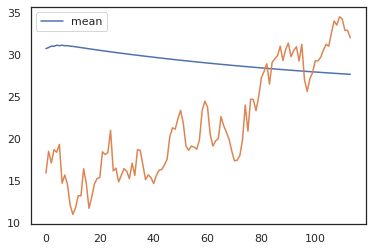

In [55]:
pd.DataFrame(ml_dict['VAR']['forecast'].set_index(clima_teste.index)['mean']).plot()
clima_teste['meantemp'].plot();

Métricas de avaliação do modelo VAR.

In [87]:
print('A raiz do erro quadrado médio do modelo VAR é :',
      round(rmse(pd.DataFrame(ml_dict['VAR']['forecast']['mean']),pd.DataFrame(clima_teste['meantemp']))[0],3))
print('O erro médio absoluto do modelo VAR é :',
      round(mean_absolute_error(pd.DataFrame(ml_dict['VAR']['forecast']['mean']),pd.DataFrame(clima_teste['meantemp'])),3))
print('O erro quadrado médio do modelo VAR é :',
      round(mean_squared_error(pd.DataFrame(ml_dict['VAR']['forecast']['mean']),pd.DataFrame(clima_teste['meantemp'])),3))
print('O erro médio quadrado logarítmico VAR é:',
      round(mean_squared_log_error(pd.DataFrame(ml_dict['VAR']['forecast']['mean']),pd.DataFrame(clima_teste['meantemp'])),3))
print('O erro mediano absoluto do modelo VAR é:',
      round(median_absolute_error(pd.DataFrame(ml_dict['VAR']['forecast']['mean']),pd.DataFrame(clima_teste['meantemp'])),3))
print('O R-squared do modelo VAR é:',
      round(r2_score(pd.DataFrame(ml_dict['VAR']['forecast']['mean']),pd.DataFrame(clima_teste['meantemp'])),3)*100,'%')

A raiz do erro quadrado médio do modelo VAR é : 10.477
O erro médio absoluto do modelo VAR é : 8.99
O erro quadrado médio do modelo VAR é : 109.766
O erro médio quadrado logarítmico VAR é: 0.2
O erro mediano absoluto do modelo VAR é: 9.219
O R-squared do modelo VAR é: -9522.3 %


## Conclusão

Concluímos, que o melhor modelo foi o gerado pelo *Facebook Prophet*, pois teve as menores métricas e o maior poder explicativo, conforme a tabela abaixo.

| ||   *RMSE*   ||  *MAE*  ||  *MSE*||  *MSLE* ||  *MedAE* ||  $R^2$ ||
|:----------------:||:------------------:||:------------------:||:------------------:||:------------------: ||:------------------:||:------------------:||
|**Prophet** || **3.173**|| **2.558** || **10.071**||**0.025**||**2.193**||**70.3%**||
|SARIMAX || 9.872|| 8.558 || 97.447|| 0.183 || 8.3||-7754.9%||
|VAR || 10.477|| 8.99 || 109.766|| 0.2 || 9.219||-9522.3%||
|*Machine Learning* || 11.747|| 10.357 || 137.99|| 0.253 || 11.693||-376.2%||
|ARIMA || 12|| 10 || 133|| 0 || 12||-46300 %||
